In [1]:
%load_ext autoreload

### VAE

In [2]:
%autoreload 2
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [3]:
import sys
sys.path.append('../')

from sb.nn.mnist import MnistVAE, MnistCLS

In [4]:
device = 'cuda:1'
vae = MnistVAE().to(device)
optimizer = torch.optim.AdamW(vae.parameters(), lr=1e-3)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

dataset = MNIST('../data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

val_dataset = MNIST('../data', train=False, download=True, transform=transform)
val_dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
n_epochs = 10
vae.train()
for epoch in range(n_epochs):
    for i, (x, _) in enumerate(dataloader):
        optimizer.zero_grad()

        x = x.to(device)
        loss, l2, kl = vae.compute_loss(x, kl_weight=1.0)
        loss.backward()
        optimizer.step()

    print(
        f'Epoch {epoch+1}/{n_epochs}, Step {i}, Loss: {loss.item():.4f}'
        f', L2: {l2.item():.4f}, KL: {kl.item():.4f}'
    )

Epoch 1/10, Step 937, Loss: 38.0360, L2: 32.0001, KL: 6.0359
Epoch 2/10, Step 937, Loss: 33.4733, L2: 26.4821, KL: 6.9912
Epoch 3/10, Step 937, Loss: 34.3897, L2: 26.1972, KL: 8.1925
Epoch 4/10, Step 937, Loss: 28.3103, L2: 20.3592, KL: 7.9511
Epoch 5/10, Step 937, Loss: 32.3878, L2: 23.9683, KL: 8.4195
Epoch 6/10, Step 937, Loss: 31.0848, L2: 22.7087, KL: 8.3761
Epoch 7/10, Step 937, Loss: 31.3384, L2: 22.5974, KL: 8.7410
Epoch 8/10, Step 937, Loss: 28.9161, L2: 20.3934, KL: 8.5227
Epoch 9/10, Step 937, Loss: 30.4718, L2: 22.0438, KL: 8.4280
Epoch 10/10, Step 937, Loss: 31.8465, L2: 23.2982, KL: 8.5483


In [18]:
# torch.save(
#     vae.state_dict(),
#     "../assets/checkpoints/vae/vae_mnist.pth"
# )

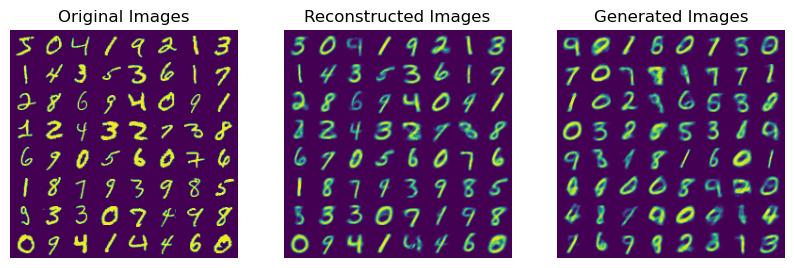

In [20]:
x_eval, _ = next(iter(val_dataloader))
x_pred, *_ = vae(x_eval.to(device))
x_pred = x_pred.view(-1, 1, 28, 28).repeat(1, 3, 1, 1).cpu()

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

x_ = x_eval.reshape(-1, 1, 28, 28).repeat(1, 3, 1, 1)
ax[0].set_title('Original Images')
ax[0].imshow(make_grid(x_, nrow=8, normalize=True)[0])
ax[0].axis('off')

ax[1].set_title('Reconstructed Images')
ax[1].imshow(make_grid(x_pred, nrow=8, normalize=True)[0])
ax[1].axis('off')

with torch.no_grad():
    z = torch.randn(64, 10, device=device)
    x_gen = vae.decoder(z)
    x_gen = x_gen.view(-1, 1, 28, 28).repeat(1, 3, 1, 1).cpu()
ax[2].set_title('Generated Images')
ax[2].imshow(make_grid(x_gen, nrow=8, normalize=True)[0])
ax[2].axis('off')

plt.show()

### Classification

In [21]:
cls_model = MnistCLS(784, 10).to(device)

cls_opt = torch.optim.AdamW(cls_model.parameters(), lr=1e-3)

In [22]:
n_epochs = 10
for epoch in range(n_epochs):
    for i, (x, y) in enumerate(dataloader):
        cls_opt.zero_grad(set_to_none=True)
        x, y = x.to(device), y.to(device)
        
        if torch.rand(1) < 0.5:
            x, *_ = vae(x)

        logits = cls_model(x)

        loss = nn.CrossEntropyLoss()(logits, y)
        loss.backward()
        cls_opt.step()

    print(f'Epoch {epoch+1}/{n_epochs}, Step {i}, Loss: {loss.item():.4f}')

Epoch 1/10, Step 937, Loss: 0.2877
Epoch 2/10, Step 937, Loss: 0.3096
Epoch 3/10, Step 937, Loss: 0.2009
Epoch 4/10, Step 937, Loss: 0.0321
Epoch 5/10, Step 937, Loss: 0.3402
Epoch 6/10, Step 937, Loss: 0.3154
Epoch 7/10, Step 937, Loss: 0.0381
Epoch 8/10, Step 937, Loss: 0.1090
Epoch 9/10, Step 937, Loss: 0.4598
Epoch 10/10, Step 937, Loss: 0.4868


In [24]:
sum_, num = 0.0, 0.0
for x, y in val_dataloader:
    logits = cls_model(x.to(device)).cpu()
    y_pred = logits.argmax(dim=1)
    
    sum_ += (y_pred == y).float().sum()
    num += y.size(0)

print(f'Accuracy: {sum_ / num:.4f}')

Accuracy: 0.9913


In [25]:
vae.state_dict().keys(), cls_model.state_dict().keys()

(dict_keys(['encoder', 'decoder']), dict_keys(['cls']))

In [ ]:
reward = {
    "generator": vae.state_dict()['decoder'],
    "classifier": cls_model.state_dict()
}
torch.save(reward, "../reward_ckpt/mnist_reward.pth")

In [30]:
r = Reward(5)
r.load_state_dict(reward_state_dict)
r.eval()

z = torch.randn(64, 10)
y = 5

reward = r(z)
(reward.reshape(8, 8) * 1000).round() / 1000


tensor([[0.7400, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.5250],
        [0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.9450, 0.0000, 1.0000, 0.0000, 0.9920, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0010, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9010, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3140]])

(np.float64(-0.5), np.float64(241.5), np.float64(241.5), np.float64(-0.5))

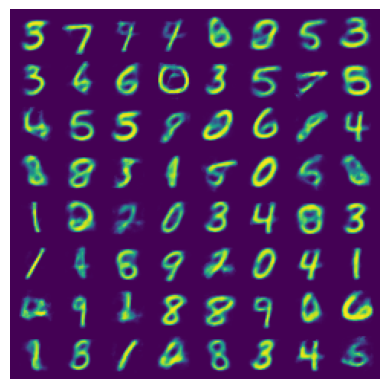

In [31]:
x = vae.decoder(z)
x = x.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
plt.imshow(make_grid(x, nrow=8, normalize=True)[0])
plt.axis('off')